In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from scipy.signal.windows import hann
import datetime

In [3]:
def read_binary_data(fname, value_label='B'):
    data_in = np.fromfile(fname, dtype=np.double)
    labview_epoch = datetime.datetime(year=1904, month=1, day=1, hour=0,minute=0, second=0) - datetime.timedelta(hours=1)
    unix_epoch = datetime.datetime.fromtimestamp(86400) - datetime.timedelta(days=1)

    idx = data_in[0::3]
    time_epoch = data_in[1::3]
    data = data_in[2::3]

    time_UTC = []

    for t in time_epoch:
        time_UTC.append( datetime.datetime.fromtimestamp(t - (unix_epoch - labview_epoch).total_seconds()) )
    out = pd.DataFrame({'t': pd.to_datetime(time_UTC),
                        'idx': idx,
                        value_label: data})
    return out

In [4]:
data_folder = '../data/2020-07-01-B-field-E-supply/'
df_B = read_binary_data(data_folder + 'UTC1306z+_+00uT_shield.dat')

(array([737607.58333333, 737607.66666667, 737607.75      , 737607.83333333,
        737607.91666667, 737608.        , 737608.08333333, 737608.16666667,
        737608.25      ]),
 <a list of 9 Text xticklabel objects>)

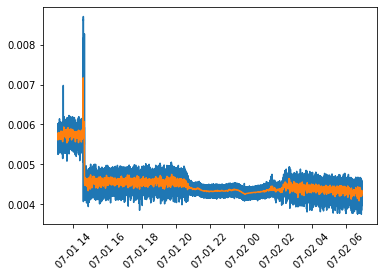

In [5]:
plt.plot(df_B['t'], df_B['B'])
df_rs = df_B.resample(rule='30S', on='t').mean().reset_index()
plt.plot(df_rs['t'], df_rs['B'])
plt.xticks(rotation=45)

In [6]:
E = np.load(data_folder + '2020-07-01-E-supply.npz')
df_E = pd.DataFrame(E['data_num'])
df_E.columns = ['meas_time', 'V1_rms', 'V2_rms', 'V1_max', 'V2_max', 'V1_min', 'V2_min', 'V1_dc', 'V2_dc', 'V1_peak-to-peak' ,'V2_peak-to-peak' ,'V1_ac', 'V2_ac', 'V1_f', 'V2_f']
df_E['t'] = pd.to_datetime(E['data_str'])
df_E['t'] += pd.Timedelta('13min') # fix lateness
df_E['t'] -= pd.Timedelta('3h') # move to UTC

In [7]:
df_E

meas_time   V1_rms   V2_rms   V1_max   V2_max   V1_min   V2_min  \
0         0.019998  236.679  228.235  334.974  317.467 -334.942 -317.223   
1         0.019991  236.734  228.142  334.925  317.429 -334.939 -317.461   
2         0.019991  236.726  228.002  335.022  316.718 -335.010 -317.054   
3         0.019991  236.734  228.024  334.874  316.811 -334.913 -316.841   
4         0.019998  236.670  228.388  335.074  317.024 -334.900 -317.294   
...            ...      ...      ...      ...      ...      ...      ...   
3577611   0.020011  234.806  228.316  332.866  316.743 -332.944 -317.471   
3577612   0.020011  234.801  228.434  332.873  316.963 -332.922 -317.953   
3577613   0.020018  234.752  228.566  332.908  317.965 -332.938 -317.762   
3577614   0.020011  234.811  228.439  332.921  317.361 -332.948 -317.756   
3577615   0.020018  234.771  228.432  332.944  317.011 -332.938 -317.730   

            V1_dc     V2_dc  V1_peak-to-peak  V2_peak-to-peak    V1_ac  \
0        0.009859  0.087499          669.916          634.690  236.679   
1        0.011339 -0.108660          669.864          634.890  236.734   
2        0.000243 -0.036180          670.032          633.771  236.726   
3        0.010665  0.058250          669.787          633.652  236.734   
4        0.010096  0.037033          669.974          634.318  236.670   
...           ...       ...              ...              ...      ...   
3577611 -0.006748 -0.122068          665.810          634.215  234.806   
3577612 -0.000451 -0.184793          665.794          634.916  234.801   
3577613 -0.002263  0.090743          665.845          635.727  234.752   
3577614 -0.004009 -0.063027          665.868          635.117  234.811   
3577615  0.008578  0.045155          665.881          634.741  234.771   

           V2_ac     V1_f     V2_f                       t  
0        228.234  50.0050  50.0050 2020-07-01 11:03:05.276  
1        228.142  50.0215  50.0215 2020-07-01 11:03:05.296  
2        228.002  50.0215  50.0215 2020-07-01 11:03:05.316  
3        228.024  50.0215  50.0215 2020-07-01 11:03:05.336  
4        228.388  50.0050  50.0050 2020-07-01 11:03:05.356  
...          ...      ...      ...                     ...  
3577611  228.316  49.9720  49.9720 2020-07-02 06:55:37.712  
3577612  228.434  49.9720  49.9720 2020-07-02 06:55:37.732  
3577613  228.566  49.9555  49.9555 2020-07-02 06:55:37.752  
3577614  228.439  49.9720  49.9720 2020-07-02 06:55:37.772  
3577615  228.432  49.9555  49.9555 2020-07-02 06:55:37.792  

[3577616 rows x 16 columns]

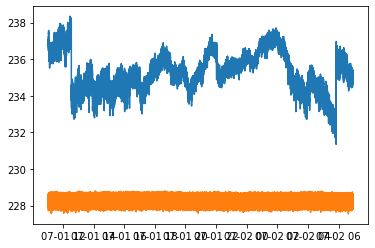

In [28]:
# drop bad vals
df_E_t = df_E.loc[df_E['V1_rms'] > 100]
plt.plot(df_E_t['t'], df_E_t['V1_rms'])
plt.plot(df_E_t['t'], df_E_t['V2_rms'])

In [27]:
sum(df_E['V1_rms'] < 200.) / len(df_E.index)

0.00026609898882384245

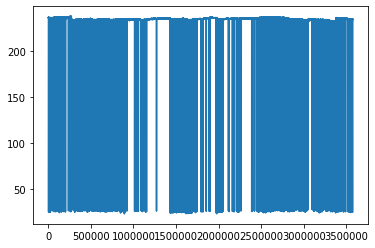

In [44]:
plt.plot(df_E['V1_rms'], label='V1')

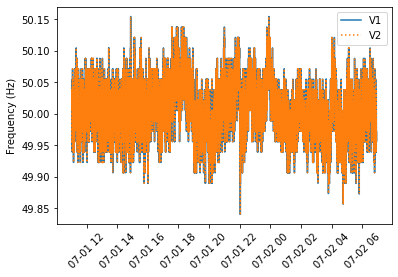

In [33]:
plt.plot(df_E['t'], df_E['V1_f'], label='V1')
plt.plot(df_E['t'], df_E['V2_f'], linestyle=':', label='V2')
plt.ylabel('Frequency (Hz)')
plt.xticks(rotation=45)
plt.legend()

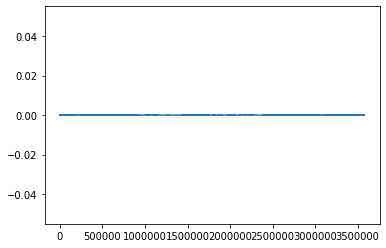

In [70]:
plt.plot(df_E['V1_f'] - df_E['V2_f'])

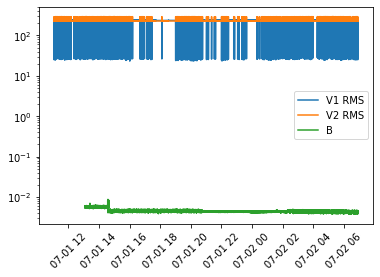

In [34]:
plt.semilogy(df_E['t'], df_E['V1_rms'], label='V1 RMS')
plt.semilogy(df_E['t'], df_E['V2_rms'], label='V2 RMS')
plt.semilogy(df_B['t'], df_B['B'], label='B')
plt.xticks(rotation=45)
plt.legend()

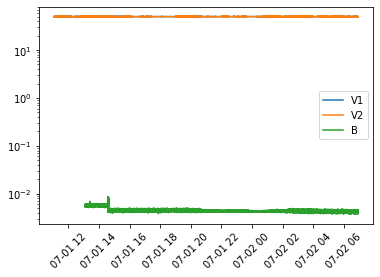

In [35]:
plt.semilogy(df_E['t'], df_E['V1_f'], label='V1')
plt.semilogy(df_E['t'], df_E['V2_f'], label='V2')
plt.semilogy(df_B['t'], df_B['B'], label='B')
plt.xticks(rotation=45)
plt.legend()

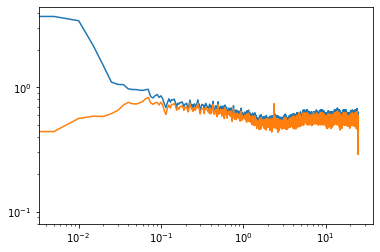

In [74]:
f_E, w_E = welch(df_E['V1_ac'] - np.mean(df_E['V1_ac']), fs=1./np.mean(df_E['meas_time']), window=hann(10000))
f_E2, w_E2 = welch(df_E['V2_ac'] - np.mean(df_E['V2_ac']), fs=1./np.mean(df_E['meas_time']), window=hann(10000))
f_B, w_B = welch(df_B['B'], fs=200, window=hann(10000))
plt.loglog(f_E, w_E)
plt.loglog(f_E2, w_E2)
#plt.loglog(f_B, w_B)

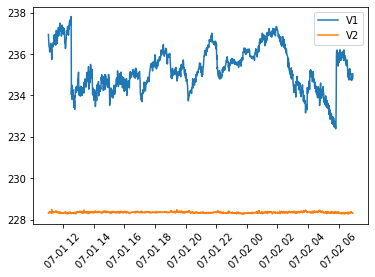

In [75]:
df_E_rs = df_E.resample('1min', on='t').mean()
plt.plot(df_E_rs.index, df_E_rs['V1_rms'], label='V1')
plt.plot(df_E_rs.index, df_E_rs['V2_rms'], label='V2')
plt.xticks(rotation=45)
plt.legend()

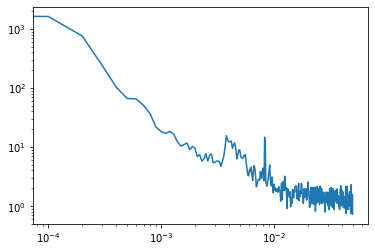

In [52]:
f_E, w_E = welch(df_E_rs['V1_rms'], fs=1./10, window=hann(1000))
plt.loglog(f_E, w_E)

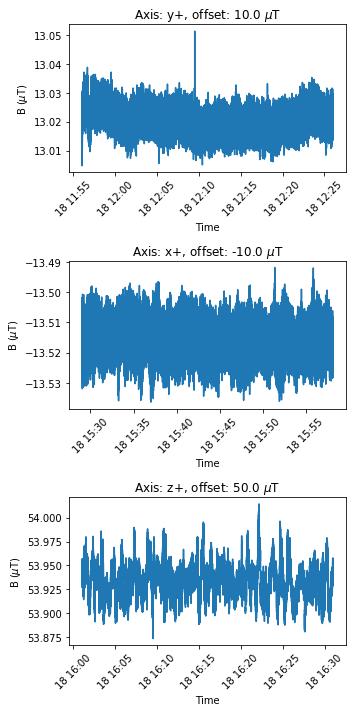

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
m30s = {k:v for k,v in data.items() if '30m' in k}
for (key, df), ax in zip(m30s.items(), axs):
    ax.plot(df['t'], df['B'])
    ax.set_ylabel(r"B ($\mu$T)")
    ax.set_xlabel("Time")
    ax.set_title(rf"Axis: {key[:2]}, offset: {df['offset'].iloc[0]} $\mu$T")
    ax.tick_params('x',labelrotation=45)
plt.tight_layout()
plt.savefig('../figs/B-field_30min.pdf', dpi=150)

0.14068603520000522


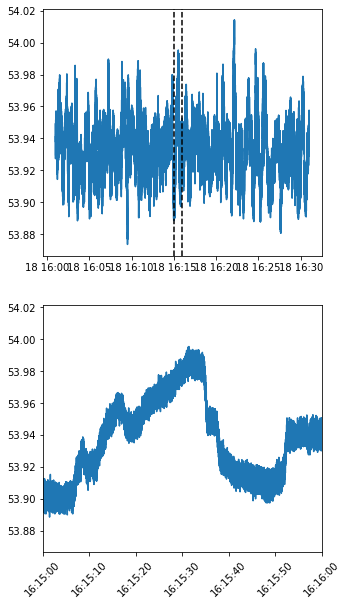

In [7]:
xlim_a = pd.to_datetime('2020-06-18 16:15:00.000')
xlim_b = pd.to_datetime('2020-06-18 16:16:00.000')
xlims = (xlim_a, xlim_b)
df = data['z+30m']
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
axs[0].plot(df['t'], df['B'])
axs[0].axvline(xlim_a, linestyle='--', color='k')
axs[0].axvline(xlim_b, linestyle='--', color='k')
axs[1].plot(df['t'], df['B'])
axs[1].set_xlim(xlims)
axs[1].tick_params('x',labelrotation=45)
print(np.max(df['B']) - np.min(df['B']))

(array([-25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
        -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
          1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25]),
 array([0.59017158, 0.60656241, 0.62295471, 0.63934444, 0.65573971,
        0.67213347, 0.68852759, 0.70492999, 0.72132072, 0.73771333,
        0.75411366, 0.77050088, 0.78689742, 0.80329046, 0.81969023,
        0.83607441, 0.85246558, 0.86885735, 0.88524928, 0.90163798,
        0.91802909, 0.93442028, 0.9508097 , 0.96720909, 0.98359867,
        1.        , 0.98359867, 0.96720909, 0.9508097 , 0.93442028,
        0.91802909, 0.90163798, 0.88524928, 0.86885735, 0.85246558,
        0.83607441, 0.81969023, 0.80329046, 0.78689742, 0.77050088,
        0.75411366, 0.73771333, 0.72132072, 0.70492999, 0.68852759,
        0.67213347, 0.65573971, 0.63934444, 0.62295471, 0.60656241,
        0.59017158]),
 <matplot

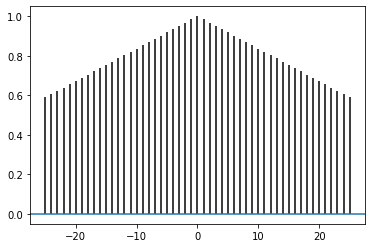

In [8]:
plt.acorr(df_rs['B'], maxlags=25)

In [9]:
df = data['y+30m']
(find_peaks(np.fft.fft(df['B'])[1:], height=100)[0] * 0.005) / 60

array([1.66666667e-04, 3.00218333e+01])

In [10]:
# huge measurement
data_folder = '../data/2020-06-18_B-field_weekend/'
f = 'meas_18_06_UTC1633z+_+50uT.txt'
s_t = pd.to_datetime('2020-06-18 ' + f.split('_')[3][:-2][-4:])
df_huge = pd.read_csv(data_folder + f, header=None, names=['B'])
offset = float(f.split('_')[-1][:3])
df_huge['B'] = df_huge['B'] * 100 + offset
df_huge['t'] = pd.date_range(start=s_t, periods=len(df_huge.index), freq='5ms')

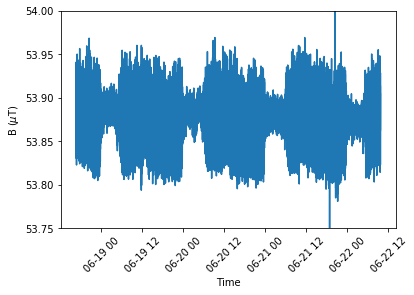

In [11]:
plt.plot(df_huge['t'], df_huge['B'])
plt.ylabel(r'B ($\mu$T)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylim([53.75, 54.0])
plt.savefig("../figs/B-field_midsummer.pdf", dpi=150)

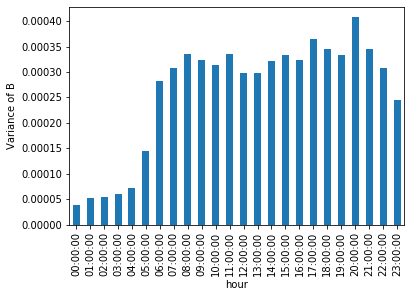

In [12]:
### hourly variance
df_huge['hour'] = df_huge['t'].dt.floor('H')
df_huge['hour'] = df_huge['hour'].dt.time
grouped = df_huge.groupby('hour')['B']
variances = grouped.var()
variances.plot.bar()
plt.ylabel(r'Variance of B')
plt.savefig("../figs/B-var_midsummer.pdf", dpi=150)

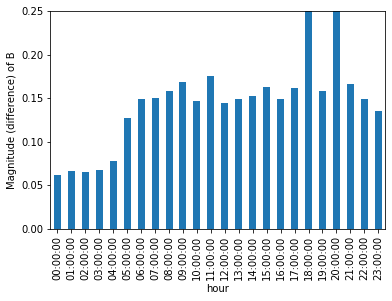

In [15]:
magnitude = grouped.max() - grouped.min()
magnitude.plot.bar()
plt.ylabel(r'Magnitude (difference) of B')
plt.ylim([0, .25])
plt.savefig("../figs/B-mag_midsummer.pdf", dpi=150)

In [11]:
np.max(df_huge['B']) - np.min(df_huge['B'])

1.207275390600003

In [29]:
data_folder = '../data/2020-06-23-B-field/'
f_names = os.listdir(data_folder)
for f in f_names:
    if not 'test' in f:
        key = f.split('_')[3][-2:] + ('flash' if 'flash' in f else 'long')
        s_t = pd.to_datetime(('2020-06-23 ' if '23' in f else '2020-06-24 ') + f.split('_')[3][:-2][-4:])
        df = pd.read_csv(data_folder + f, header=None, names=['B'])
        offset = float(f.split('_')[4][:3])
        df['B'] = df['B'] * 100 + offset
        df['offset'] = offset
        df['t'] = pd.date_range(start=s_t, periods=len(df.index), freq='5ms')
        data[key] = df

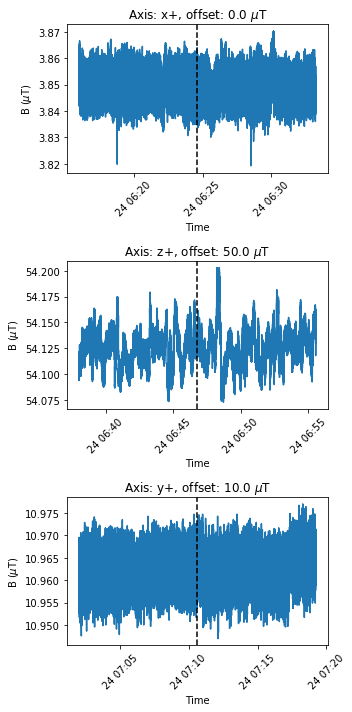

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
flashes = {k:v for k,v in data.items() if 'flash' in k}
for (key, df), ax in zip(flashes.items(), axs):
    ax.plot(df['t'], df['B'])
    ax.set_ylabel(r"B ($\mu$T)")
    ax.set_xlabel("Time")
    ax.set_title(rf"Axis: {key[:2]}, offset: {df['offset'].iloc[0]} $\mu$T")
    ax.tick_params('x',labelrotation=45)
    ax.axvline(df['t'].iloc[int(len(df.index)/2)], color='k', linestyle='--')
plt.tight_layout()
plt.savefig('../figs/B-field_flash.pdf', dpi=150)

In [31]:
data

{'y+30m':                 B  offset                       t
 0       13.017731    10.0 2020-06-18 11:56:00.000
 1       13.017883    10.0 2020-06-18 11:56:00.005
 2       13.015442    10.0 2020-06-18 11:56:00.010
 3       13.016968    10.0 2020-06-18 11:56:00.015
 4       13.015594    10.0 2020-06-18 11:56:00.020
 ...           ...     ...                     ...
 360261  13.023224    10.0 2020-06-18 12:26:01.305
 360262  13.022766    10.0 2020-06-18 12:26:01.310
 360263  13.022461    10.0 2020-06-18 12:26:01.315
 360264  13.022919    10.0 2020-06-18 12:26:01.320
 360265  13.020630    10.0 2020-06-18 12:26:01.325
 
 [360266 rows x 3 columns],
 'x+30m':                 B  offset                       t
 0      -13.518372   -10.0 2020-06-18 15:29:00.000
 1      -13.524475   -10.0 2020-06-18 15:29:00.005
 2      -13.516693   -10.0 2020-06-18 15:29:00.010
 3      -13.509827   -10.0 2020-06-18 15:29:00.015
 4      -13.517761   -10.0 2020-06-18 15:29:00.020
 ...           ...     ...        

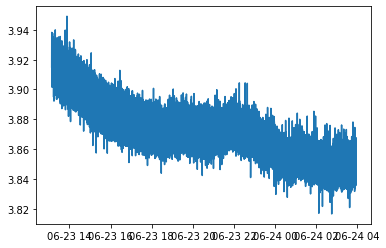

In [35]:
df = data['x+long']
plt.plot(df['t'], df['B'])